# BDM - Final Challenge (+ Extra Credit at the end)

In this final challenge, we continue our efforts in analyzing food insecurity in NYC. In the previous attemps (HW3), we didn't see a relationship between star ratings for grocery stores compared to food insecurity level in the community district. However, we were only looking at Key Food stores. We would like to extend the study to all grocery stores in NYC. To do that, we have collect store ratings data through [Google Places API](https://developers.google.com/maps/documentation/places/web-service/overview) with respect to supermarket stores. This results in over 7000 locations, but we are only interested in [1200 stores](https://nyu.carto.com/u/huyvo/builder/12ad7126-f9f4-480e-a921-0fab040d209e/) with star ratings. Unfortunately, we also do not see a clear relationshipp in this case, as shown in the plot below.

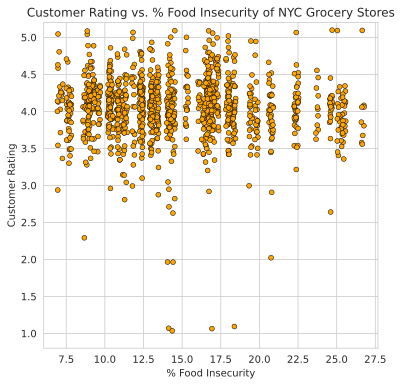

In [ ]:
#@title


Our next objective is to determine the distance people traveled to grocery stores by census block group (CBG) using [Safegraph data](https://docs.safegraph.com/docs/weekly-patterns). In particular, we would like to know for each CBG, the average distance they traveled to the listed grocery stores in March 2019, October 2019, March 2020, and October 2020. (We select March and October to avoid summer and holidays with more noise from tourists and festivity shopping). To be consistent with Safegraph, we will use haversine distance for this project.


## INPUT

### **`nyc_supermarkets.csv`**
[download](https://drive.google.com/file/d/1RmxHrY1UNVfAtU8Wut_oqz-G7nsU3Ss-/view?usp=sharing)

This CSV file contains a subset of the grocery stores that we collected through Google Places API. It is a subset because not every store has corresponding POI in the [Safegraph Places dataset](https://docs.safegraph.com/docs/core-places). 

|place_id|latitude|longitude|name|vicinity|rating|user_ratings_total|community_district|percent_food_insecurity|safegraph_placekey|safegraph_name|
|--|--|--|--|--|--|--|--|--|--|--|
|...|...|...|...|...|...|...|...|...|...|...|

In this challenge, we are only interested in the **safegraph_placekey** column which matches the **placekey** column in the Weekly Pattern dataset.


This dataset is considered *small*, and will not be stored on HDFS (when we run our job).



### **`nyc_cbg_centroids.csv`**
[download](https://drive.google.com/file/d/196F50FfY1kHJItadHcU_kQCdViV6puHT/view?usp=sharing)

This CSV file contains the centroid location for each census block group (CBG). This information will be useful in computing the haversine distance between two CBGs. The dataset has the following columns:

|cbg_fips|latitude|longitude|
|--|--|--|
|...|...|...|

**cbg_fips** refers to the FIPS code of the CBGs used in Safegraph, it has the following format:

<img src="https://drive.google.com/uc?id=1io_iPuKOtq0KThPDfpvDAQEd79l6vZVs"></img>

The FIPS code for New York State is **036**. The five boros of New York would have the following FIPS prefix:

|Boro|FIPS Prefix|
|--|--|
|Manhattan|36061...|
|Bronx|36005...
|Brooklyn|36047...|
|Queens|36081...|
|Staten Island|36085...|

This dataset is considered *small*, and will not be stored on HDFS (when we run our job).

### **`weekly-patterns-nyc-2019-2020`**
The data is located on HDFS at `/tmp/bdm/weekly-patterns-nyc-2019-2020`.

This is the *big data* part of the challenge. It is stored on HDFS at the above location. It is a subset of the [Weekly Patterns](https://docs.safegraph.com/docs/weekly-patterns) dataset from Safegraph containing visit patterns for various locations in NYC in 2019 and 2020. We are going to use this data set to derive the traveled distances. Here are the columns of interests:

* **placekey**: can be used to crosscheck with the stores in `nyc_supermarkets.csv`
* **poi_cbg**: the CBG of the store (where people travel to)
* **visitor_home_cbgs**: the list of home CBGs where the visitors were traveling from (yes, we assume they went from home to stores).
* **date_range_end**, **date_range_start**: we use these two date to determine which month the **visitor_home_cbgs** should be used for (more on the pipeline below).


## OUTPUT
You are asked to produce the following output on HDFS in CSV format with the first row of partition 0 (or every partition) containing the column header. Each cell represents the average distance (in miles) that people travel from the corresponding CBG in the month specified in the column. An empty cell suggests that there were no data for that month.

|cbg_fips|2019-03|2019-10|2020-03|2020-10|
|--|--|--|--|--|
|360050147011||0.54|3.21|0.28|
|360050177013|0.22|0.42||0.17|
|360050177023|0.33|0.22|3.45||
|...|...|...|...|...|

The data must be **sorted by `cbg_fips`**.

## APPROACH

To minize the descrepancies, we provide the logic/steps needed to derive the output:

1. Use `nyc_supermarkets.csv` to filter the visits in the weekly patterns data
2. Only visit patterns with `date_range_start` or `date_range_end` overlaps with the 4 months of interests (Mar 2019, Oct 2019, Mar 2020, Oct 2020) will be considered, i.e. either the start or the end date falls within the period.
3. Use `visitor_home_cbgs` as the travel origins, and only consider CBG FIPS for NYC (must exist in `nyc_cbg_centroids.csv`).
4. Travel distances are the distances between each CBG in `visitor_home_cbgs` with `poi_cbg`. The distance must be computed in miles. To compute the distance between coordinates locally to NYC more accurately, please project them to the EPSG 2263 first.
5. The average should be computed from the total travel distances and the total number of visitors (similar to the way we compute the average in Lab 4).

## SUBMISSION
While you can test using Colab, your final submission must be a single `.py` file that runs on NYU HPC with the following command:

```
spark-submit --executor-cores 5 --num-executors 5 --files nyc_supermarkets.csv,nyc_cbg_centroids.csv BDM_Final_NetID.py OUTPUT_FOLDER_NAME
```

Notes:
* `OUTPUT_FOLDER_NAME`: being specified by the user at run-time. You can access this variable through `sys.argv[1]` in your code. Your code must output data into this folder (e.g. through `saveAsTextFile`).
* `nyc_supermarkets.csv` and `nyc_cbg_centroids.csv` will be in the same folder with your code when we evaluate your assignment.

##**TIME LIMIT**: your code must not take more than 5 minutes to complete.

## DATA SAMPLING

We would like to take advantage of the interactivity of a notebook to develop our Spark's pipeline. Ideally, we would like to have both data sets available on Colab for developoment. However, the pattern data set is considerably large (10GB), and would be expensive (in term of computing resources) to upload and work with them from here. So our strategy is to *sample* the pattern data set to only 1% (~100MB). We will use the POI data set as is.

The simple code below can be used for sampling 1% of the pattern data. We make use of [RDD's sample() method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html#pyspark.RDD.sample) for this task. The first argument (`False`) is to specify that we would like to do a sample without replacement. Note that we separate the header and union it with the sampled data set to retained the header after sampling.

```python
from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    rdd = sc.textFile('/tmp/bdm/weekly-patterns-nyc-2019-2020/*')
    header = rdd.first()
    rdd.sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('weekly-patterns-nyc-2019-2020-sample')
```

### A. [TODO] Run the above script on our cluster
Please save the above code snippet into a Python file, then choose a method of your choice (e.g. GitHub, HUE, or using `scp`) to transfer this script onto your storage on the cluster.

Assuming that you have named the script as `BDM_Final_Sample.py`, then once on the cluster, run the script with the following command:

```
spark-submit --num-executors 5 --executor-cores 5 BDM_Final_Sample.py
```

After running the script, there should be a new folder created on your home folder on HDFS: `weekly-patterns-nyc-2019-2020-sample`. There should only be a file in that folder. That should be our sampled CSV file.


NOTE: a few common errors that you might be running into:
- If you had run the above command before, you have to remove the existing output folder by running the following command:
> `hadoop fs -rm -r -skipTrash weekly-patterns-nyc-2019-2020-sample`



### B. [TODO] Download data sets to the notebook
Download the file from Step A and upload to your Google Drive. Make sure to enable the share option of "Any with link" to the file, and copy its ID in the shared link. Run the below command to have the `weekly-patterns-nyc-2019-2020-sample.csv` file available to our notebook. Remember to replace ID with your file id. You can double check if the file is right by using the Files tab on the left.

In [ ]:
!curl -L "https://drive.google.com/uc?id=YOUR_FILE_ID&confirm=t" > weekly-patterns-nyc-2019-2020-sample.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  108M  100  108M    0     0   114M      0 --:--:-- --:--:-- --:--:--  114M


In [ ]:
!head weekly-patterns-nyc-2019-2020-sample.csv 

"placekey","safegraph_place_id","parent_placekey","parent_safegraph_place_id","location_name","street_address","city","region","postal_code","iso_country_code","safegraph_brand_ids","brands","date_range_start","date_range_end","raw_visit_counts","raw_visitor_counts","visits_by_day","visits_by_each_hour","poi_cbg","visitor_home_cbgs","visitor_daytime_cbgs","visitor_country_of_origin","distance_from_home","median_dwell","bucketed_dwell_times","related_same_day_brand","related_same_week_brand","device_type"
22v-222@627-s96-xbk,sg:5a00e59019f547d0b2a6f118d7eb5b33,,,Xixa,241 S 4th St,Brooklyn,NY,11211,US,,,2018-12-31T00:00:00-05:00,2019-01-07T00:00:00-05:00,59,23,"[7,2,12,18,8,6,6]","[0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,2,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## EXTRA CREDIT 1 (+5 PTS)

Please compute the median traveled distances instead of the mean. The output format should be the same as above. Your submission should be `BDM_Final_EC1_NetID.py`.

## EXTRA CREDIT 2 (+5 PTS)

Please compute the statistics for all grocery stores in the Safegraph data. Instead of filtering the travel patterns to match the placekeys in `nyc_supermarkets.csv`, you are asked to match all placekeys with `naics_code` starts with `4451` in the `core-places-nyc`. The output format should be the same as above. Your submission should be `BDM_Final_EC2_NetID.py`.

### **`core-places-nyc`**
The data is located on HDFS at `/tmp/bdm/core-places-nyc` but you can also [download](https://drive.google.com/file/d/12Na0tfjPa8OpgL9hW6RbI3ppQSdxOxg4/view?usp=sharing) for inspection.

The file has the same schema as [Safegraph Places](https://docs.safegraph.com/docs/core-places). We just filter it to fit in the NYC region.
